# Compute Architecure - Assessment
**Course**: TU 2025 25-26: 8645 -- COMPUTER INFRASTRUCTURE  
**Lecturer**: Ian McLauglin  
**Author**: Clyde Watts  








### Imports

yfinance - financial ticker data from yahoo  - [yfinance](https://github.com/ranaroussi/yfinance)
datetime - pythons inbuild date time
logging - python logging
os - operating system functions
glob - file selector

In [1]:

import logging
from datetime import datetime, timedelta
import os
import pathlib as Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns
import numpy as np
import yfinance as yf

##  Initialisation

In [2]:
# init logging
logging.basicConfig(level=logging.INFO)

In [3]:
# Delete all CSV files in the data directory
data_path = "./data/"
files = glob.glob(os.path.join(data_path, "*.csv"))
for f in files:
    print(f"Deleting file: {f}")
    os.remove(f)

Deleting file: ./data\20251103_235959.csv
Deleting file: ./data\20251109_203312.csv
Deleting file: ./data\20251109_203322.csv


### Helper Functions 




__Function: print_status__

Prints the status with a green tick or red cross. This makes it easier to validate function return codes

In [4]:





def print_status(return_code, description, return_message):
    """
    Print status with visual indicator
    
    Args:
        return_code (int): 0 for success, non-zero for failure
        description (str): Status description
        return_message (str): Related file name
    """
    if return_code == 0:
        # Green tick for success (bold)
        status_symbol = "\033[1;92m✓\033[0m"  # Bold green checkmark
    else:
        # Red X for failure (bold)
        status_symbol = "\033[1;91m✗\033[0m"  # Bold red X

    # Print entire line in bold
    print(f"\033[1m{status_symbol} Status: {return_code}, Message: {description}, File: {return_message}\033[0m")


__Smoke Test__

In [5]:
print("Smoke Test Results:")
print_status(0, "Latest file retrieval", "file_name.csv")
print_status(1, "File retrieval failed", "file_name.csv")

Smoke Test Results:
✓ Status: 0, Message: Latest file retrieval, File: file_name.csv
✗ Status: 1, Message: File retrieval failed, File: file_name.csv


## Problem 1: Data from yfinance

Using the [yfinance](https://github.com/ranaroussi/yfinance) Python package, write a function called `get_data()` that downloads all hourly data for the previous five days for the five FAANG stocks:

- Facebook (META)
- Apple (AAPL)
- Amazon (AMZN)
- Netflix (NFLX)
- Google (GOOG)

The function should save the data into a folder called `data` in the root of your repository using a filename with the format `YYYYMMDD-HHmmss.csv` where `YYYYMMDD` is the four-digit year (e.g. 2025), followed by the two-digit month (e.g. `09` for September), followed by the two digit day, and `HHmmss` is hour, minutes, seconds.
Create the `data` folder if you don't already have one.

## Problem 1: Requirements ##

### Extract ###

1.  Extract from yfinance data the stock data for META,AAPL,AMZN,NFLX,GOOG
2.  For 5 complete previous days trading , we need to take into account that NASDAQ trades from Monday to Friday. If we go back 7 days we will always ignore weekends
3.  File format will YYYYMMDD-HHmmss.csv where YYYY - is 4 digit year , MM month 01-12 , DD - is 01-31. HH - hours , 24 our clock , mm - minutes 00-59 , seconds 00-59.
4.  Grain - Hour

Column
Date , <ticket> ( Open,High,Low,Close,Volume) ....
ticket is META , AAPL , AMZN , NFLX or GOOG
Open - open price
Close - close price
High - High pricr
Low - Low price
Volumn - Volume in period

The data frame return has an index on the date , and is a multilevel index. Level one is the ticket , and the second level is the metric - that is open , close , high , low prices and volume 
 
No problem! That's the best way to tackle a multi-part assignment—make a clear plan for each piece.

Here is a requirements checklist for "Problem 1" that matches the format you provided.

### Assignment: Problem 1 Requirements Specification

Here is a checklist of all the tasks the `get_data()` function must accomplish:

**1. Data Specification**
* [✅] Define the list of target tickers: META, AAPL, AMZN, NFLX, and GOOG.
* [✅] Define the data interval as "hourly".
* [✅] Define the data period as the "previous five days".

**2. Data Fetching**
* [✅] Use the `yfinance` Python package.
* [✅] Write code to download the data for all five tickers based on the interval and period.
* [✅] Store the downloaded data, likely in a `pandas` DataFrame.

**3. Folder Management**
* [✅] Check if a folder named `data` exists in the root of the repository.
* [✅] If the `data` folder does not exist, create it.

**4. File Output**
* [✅] Get the current date and time.
* [✅] Format the current date and time into a string `YYYYMMDD-HHmmss`.
* [✅] Create the full output path by combining the `data` folder, the formatted datetime string, and the `.csv` extension.
* [✅] Save the downloaded data DataFrame to this CSV file.



__Function : get_data__

This downloads the latest data for a number of listed stock companies using yfinance module and writes to CSV file. 

In [6]:
# prototype for extracting stock data
tickers = ["META", "AAPL", "AMZN", "NFLX", "GOOG"]
def get_data(tickers = tickers,start_date=None, end_date=None,interval="1h",data_path="./data/"):
    """
    Function to get stock data from yfinance

    Parameters:
    tickers (list): List of stock tickers to download data for
    start_date (str): Start date for data in format "YYYY-MM-DD". If None, defaults to 6 days ago.
    end_date (str): End date for data in format "YYYY-MM-DD". If None, defaults to yesterday.
    interval (str): Data interval. Default is "1h".
    data_path (str): Path to save the data. Default is "./data/".
    Returns:
       return_code : 0 for success, -1 for failure
       return_message : message indicating success or failure
       file_name (str): Name of the file where data is saved
    """
    return_code = 0
    return_message = "Success"
    file_name = None
    if start_date is None:
        # Variation of the fence posting to get last 7 days of data
        start_date = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%d")
        # create file name based on current date and time
        file_name = f"{data_path}{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    else:
        # convert start_date to datetime object
        start_date_time = datetime.strptime(start_date, "%Y-%m-%d")
        # create file name based on start time and 23:59:59 of end date
        start_date_str = start_date_time.strftime("%Y%m%d") + "_235959"
        file_name = f"{data_path}{start_date_str}.csv"
    # if end_date is None , set to today - 0 days this means yesterday's data inclusive
    if end_date is None:
        end_date = (datetime.now() - timedelta(days=0)).strftime("%Y-%m-%d")
    else: # convert end_date to datetime object
        end_date_time = datetime.strptime(end_date, "%Y-%m-%d")
        # add 1 day to end_date to make it inclusive
        end_date = (end_date_time + timedelta(days=1)).strftime("%Y-%m-%d")
    # check if directory exists
    if not os.path.exists(data_path):
        logging.info(f"Creating directory: {data_path}")
        try:
            os.makedirs(data_path)
        except Exception as e:
            logging.error(f"Error creating directory: {e}")
            return_code = -1
            return_message = f"Error creating directory: {e}"
            return return_code, return_message, None
    # if file exists then delete it
    if os.path.exists(file_name):
        logging.info(f"Deleting existing file: {file_name}")
        try:
            os.remove(file_name)
        except Exception as e:
            logging.error(f"Error deleting file: {e}")
            return_code = -1
            return_message = f"Error deleting file: {e}"
            return return_code, return_message, None
    logging.info(f"Start Date: {start_date}, End Date: {end_date}")
    try:
        df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
    except Exception as e:
        logging.error(f"Error downloading data: {e}")
        return_code = -1
        return_message = f"Error downloading data: {e}"
        return return_code, return_message, None
    # Save the data to a CSV file
    df_data.to_csv(file_name)
    return return_code, return_message, file_name
   



In [7]:
print("Starting data download...")
return_code, return_message, file_name = get_data(tickers=tickers)
print_status(return_code, return_message, file_name)
df_data = get_data(tickers=tickers) 

INFO:root:Start Date: 2025-11-02, End Date: 2025-11-09


Starting data download...


C:\Users\cw171001\AppData\Local\Temp\ipykernel_87736\3298150898.py:61: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed
INFO:root:Start Date: 2025-11-02, End Date: 2025-11-09
C:\Users\cw171001\AppData\Local\Temp\ipykernel_87736\3298150898.py:61: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


✓ Status: 0, Message: Success, File: ./data/20251109_213501.csv


## Problem 2: Plotting Data

Write a function called `plot_data()` that opens the latest data file in the `data` folder and, on one plot, plots the `Close` prices for each of the five stocks.
The plot should include axis labels, a legend, and the date as a title.
The function should save the plot into a `plots` folder in the root of your repository using a filename in the format `YYYYMMDD-HHmmss.png`.
Create the `plots` folder if you don't already have one.


### Assignment: Problem 2 Requirements Specification

Here is a checklist of all the tasks the `plot_data()` function must accomplish:

**1. File Input & Data Loading**
* [✅] Access the `data` folder.
* [✅] Identify the *latest* file in the `data` folder (e.g., by checking file modification time or finding the most recent date in the filename).
* [✅] Open and read the data from this file (assuming it's a format like CSV, likely using `pandas`).

**2. Data Processing**
* [✅] Extract the `Close` price columns for all five stocks.
* [✅] Ensure the corresponding date/time data is available to be used for the x-axis.

**3. Plot Generation & Styling**
* [✅] Create a *single* plot figure.
* [✅] Plot all five `Close` price series as lines on this single plot.
* [✅] Set a clear label for the x-axis (e.g., "Date").
* [✅] Set a clear label for the y-axis (e.g., "Closing Price ($)").
* [✅] Add a legend that correctly identifies each of the five stocks.
* [✅] Get the *current* date and time.
* [✅] Set the plot's title to the current date (e.g., "Stock Prices as of YYYY-MM-DD").

**4. File Output**
* [✅] Check if a folder named `plots` exists in the root directory.
* [✅] If the `plots` folder does not exist, create it.
* [✅] Generate a filename based on the current date and time in `YYYYMMDD-HHmmss` format (e.g., `20251109-161120`).
* [✅] Save the generated plot to the `plots` folder using the generated filename with a `.png` extension.
* [✅] Ensure the plot is closed after saving to free up resources.



[glob](https://docs.python.org/3/library/glob.html)



__Function: print_status__

This prints the status. 

Clear Down Data before test

__Function : get_the_latest_file__

This scans directory ./data ( parameter ) using a pattern 20....csv to get the latest file and returns the file name

In [8]:
#------------------------------------------------------------------------------
# Function to get the latest file from a directory
#------------------------------------------------------------------------------

def get_latest_file(data_path="./data/"):
    """
    Returns the path to the latest data file in the specified directory.

    Args:
        data_path (str): The path to the directory containing the data files.

        tuple: (return_code, return_message, latest_file) where latest_file is the path to the latest data file, or None if no files are found.
        str: The path to the latest data file, or None if no files are found.
    """
    return_code = 0
    return_message = "Success"
    latest_file = None

    logging.info(f"Getting the latest file from {data_path}")
    # File pattern
    file_pattern = "20[0-9][0-9][0-1][0-9][0-3][0-9]_[0-9][0-9][0-9][0-9][0-9][0-9].csv"
    # Add path to file pattern
    file_pattern = os.path.join(data_path, file_pattern)
    # glob searches directories for files based on a pattern
    try:
        list_of_files = glob.glob(file_pattern)
    except Exception as e:
        logging.error(f"Error occurred while searching for files: {e}")
        return_code=-1
        return_message=f"Error occurred while searching for files: {e}"
        return return_code, return_message, None
    if not list_of_files:
        logging.warning(f"No files found in {data_path} matching pattern {file_pattern}")
        return_code = -1
        return_message = f"No files found in {data_path} matching pattern {file_pattern}"
        return return_code, return_message, None
    # find the latest file based on creation time
    #    max parameters - list and function which gets "value" associated with each item in the list
    #    this gets the "youngest" file based on creation time 
    #    not necessarily the latest date in the file name - design decision 
    #    the premise is that the latest file created is the one we want to use
    latest_file = max(list_of_files, key=os.path.getctime)
    logging.info(f"Latest file: {latest_file}")
    return return_code, return_message, latest_file

__Function: get_PNG_filename_from_CSV_filename__

In [9]:
def get_PNG_filename_from_CSV_filename(csv_filename,plot_path="./plots/"):
    """
    Function to get PNG filename from CSV filename

    Parameters:
    csv_filename (str): Name of the CSV file
    plot_path (str): Path to save the PNG file. Default is "./plots/".

    Returns:
       png_filename (str): Name of the PNG file
    """
    return_code = 0
    return_message = "Success"
    # extract base name from csv_filename
    base_name = os.path.basename(csv_filename)
    # remove .csv extension
    base_name = os.path.splitext(base_name)[0]
    # create png filename
    png_filename = f"{plot_path}{base_name}.png"
    return return_code, return_message, png_filename

### Load data from 

In [10]:
return_code, return_message, file_name = get_latest_file()
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {file_name}", return_message)
# now get png file name from csv file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(file_name, "./plots/")
print_status(return_code, f"PNG file path retrieval - Return Code: {return_code}, Message: {return_message}, File: {png_file_path}", return_message)


INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251109_213504.csv


✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251109_213504.csv, File: Success
✓ Status: 0, Message: PNG file path retrieval - Return Code: 0, Message: Success, File: ./plots/20251109_213504.png, File: Success


__Function : load_file_into_dataframe__

This loads the file name into data frame

In [11]:
def load_file_into_dataframe(file):
    """load_file_into_dataframe

    Args:
        file (str): The path to the data file.

    Returns:
        tuple: (return_code, return_message, df) where:
            return_code (int): 0 for success, -1 for failure
            return_message (str): Success or error message
            df (pd.DataFrame): The data as a pandas DataFrame with multi-level columns
    """
    return_code = 0
    return_message = "Success"
    df = None
    
    # Check if file name is provided
    if file is None:
        logging.error("No file provided to load into dataframe.")
        return_code = -1
        return_message = "No file provided to load into dataframe."
        return return_code, return_message, None
    
    # Check if file exists
    if not os.path.exists(file):
        logging.error(f"File does not exist: {file}")
        return_code = -1
        return_message = f"File does not exist: {file}"
        return return_code, return_message, None
    
    # Load the CSV file into a DataFrame with multi-level columns
    try:
        df = pd.read_csv(file, header=[0,1], index_col=0, parse_dates=True)
        logging.info(f"Successfully loaded data from {file}. Shape: {df.shape}")
    except Exception as e:
        logging.error(f"Error loading file {file}: {e}")
        return_code = -1
        return_message = f"Error loading file {file}: {e}"
        return return_code, return_message, None
    
    return return_code, return_message, df



In [12]:
print("Loading data from the latest file...")
return_code, return_message, latest_file = get_latest_file()
full_file_name = os.path.abspath(latest_file)
print(f"Loading data from file: {full_file_name}")
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

return_code, return_message, df = load_file_into_dataframe(latest_file)
print_status(return_code, f"File load - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

print(df.shape)
# convert csv file name to png file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(latest_file, "./plots/")
print(f"PNG file path: {png_file_path}")

INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251109_213504.csv
INFO:root:Successfully loaded data from ./data\20251109_213504.csv. Shape: (35, 25)


Loading data from the latest file...
Loading data from file: c:\Users\cw171001\OneDrive - Teradata\Documents\GitHub\PFDA_computer_architecture\data\20251109_213504.csv
✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251109_213504.csv, File: Success
✓ Status: 0, Message: File load - Return Code: 0, Message: Success, File: ./data\20251109_213504.csv, File: Success
(35, 25)
PNG file path: ./plots/20251109_213504.png


### Investigate Data Frame

Have a look at the dataframe and see it's structure. 

https://ranaroussi.github.io/yfinance/reference/api/yfinance.download.html#yfinance.download

The index is DatetimeIndex - that is the timestamp of the price.
The data appears Company/Ticker - and then metrics - open,high,low,close,volume



In [13]:
# Have a look at the index and columns
print(" Data Frame Info")
print(df.info(verbose=True))

 Data Frame Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35 entries, 2025-11-03 14:30:00+00:00 to 2025-11-07 20:30:00+00:00
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (META, Open)    35 non-null     float64
 1   (META, High)    35 non-null     float64
 2   (META, Low)     35 non-null     float64
 3   (META, Close)   35 non-null     float64
 4   (META, Volume)  35 non-null     int64  
 5   (GOOG, Open)    35 non-null     float64
 6   (GOOG, High)    35 non-null     float64
 7   (GOOG, Low)     35 non-null     float64
 8   (GOOG, Close)   35 non-null     float64
 9   (GOOG, Volume)  35 non-null     int64  
 10  (AMZN, Open)    35 non-null     float64
 11  (AMZN, High)    35 non-null     float64
 12  (AMZN, Low)     35 non-null     float64
 13  (AMZN, Close)   35 non-null     float64
 14  (AMZN, Volume)  35 non-null     int64  
 15  (NFLX, Open)    35 non-null     float64
 16  (NFLX, High)   

Check the first and last dates . To check if the week is being covered.
That is the fense post problem

In [14]:
# Only get the datetime index and convert to a list
datetime_index = df.index.to_series().reset_index(drop=True)
# Convert series datetime to dates and remove duplicates and sort
date_list = datetime_index.dt.date.drop_duplicates().sort_values().astype(str)
print(date_list)

0     2025-11-03
7     2025-11-04
14    2025-11-05
21    2025-11-06
28    2025-11-07
Name: Datetime, dtype: object


Investigate the time zones , the data is from US NASDAQ - Monday to Friday 9:30 to 21:30 EST , UTC+8

https://www.ig.com/en/trading-strategies/nasdaq-opening-and-closing-times--when-can-you-trade--230527#:~:text=The%20index%20opens%20at%209.30,that's%204%20am%20UTC%2B8.&text=However%2C%20you%20can%20trade%20the,a%20day%2C%20Monday%20to%20Thursday.

In [15]:
# Only get the datetime index and convert to a list
datetime_index = df.index.to_series().reset_index(drop=True)
# Extract the time zone info
time_zone = datetime_index.dt.tz
print(f"Time Zone Info: {time_zone}")
# Extract time from datetime index
time_list = datetime_index.dt.time.drop_duplicates().sort_values().astype(str)
print("Time List:")
print(time_list)
# see if the convert the timezone to EST for NASDAQ data is possible
datetime_index_est = datetime_index.dt.tz_convert('US/Eastern')
print("Datetime Index in EST:")
time_list_est = datetime_index_est.dt.time.drop_duplicates().sort_values().astype(str)
print("Time List in EST:")
print(time_list_est)

Time Zone Info: UTC
Time List:
0    14:30:00
1    15:30:00
2    16:30:00
3    17:30:00
4    18:30:00
5    19:30:00
6    20:30:00
Name: Datetime, dtype: object
Datetime Index in EST:
Time List in EST:
0    09:30:00
1    10:30:00
2    11:30:00
3    12:30:00
4    13:30:00
5    14:30:00
6    15:30:00
Name: Datetime, dtype: object


In [16]:
print("Loading data from the latest file...")
return_code, return_message, latest_file = get_latest_file()
print_status(return_code, f"Latest file retrieval - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

return_code, return_message, df = load_file_into_dataframe(latest_file)
print_status(return_code, f"File load - Return Code: {return_code}, Message: {return_message}, File: {latest_file}", return_message)    

print(df.shape)
# convert csv file name to png file name
return_code, return_message, png_file_path = get_PNG_filename_from_CSV_filename(latest_file, "./plots/")
print(f"PNG file path: {png_file_path}")
return_code, return_message, df = load_file_into_dataframe(latest_file)
print(f"Function :  Return_Code = {return_code} Return Message = {return_message}")
data_path = "./data/"



INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251109_213504.csv
INFO:root:Successfully loaded data from ./data\20251109_213504.csv. Shape: (35, 25)
INFO:root:Successfully loaded data from ./data\20251109_213504.csv. Shape: (35, 25)


Loading data from the latest file...
✓ Status: 0, Message: Latest file retrieval - Return Code: 0, Message: Success, File: ./data\20251109_213504.csv, File: Success
✓ Status: 0, Message: File load - Return Code: 0, Message: Success, File: ./data\20251109_213504.csv, File: Success
(35, 25)
PNG file path: ./plots/20251109_213504.png
Function :  Return_Code = 0 Return Message = Success


In [17]:
df

Ticker                           META                                      \
Price                            Open        High         Low       Close   
Datetime                                                                    
2025-11-03 14:30:00+00:00  656.000000  659.329895  647.210022  648.506592   
2025-11-03 15:30:00+00:00  648.505005  652.580017  646.012695  649.875000   
2025-11-03 16:30:00+00:00  649.849976  653.000000  649.270020  650.169983   
2025-11-03 17:30:00+00:00  650.169983  650.929993  643.000000  644.140015   
2025-11-03 18:30:00+00:00  644.050110  646.000000  641.559998  644.460022   
2025-11-03 19:30:00+00:00  644.460022  646.280029  641.770081  642.369995   
2025-11-03 20:30:00+00:00  642.369995  642.760010  636.210022  637.719971   
2025-11-04 14:30:00+00:00  628.039978  641.739929  626.469971  635.355774   
2025-11-04 15:30:00+00:00  635.270020  638.799988  628.390076  631.979980   
2025-11-04 16:30:00+00:00  631.992004  633.450012  630.330017  631.544983   
2025-11-04 17:30:00+00:00  631.525024  631.744995  627.599976  629.431702   
2025-11-04 18:30:00+00:00  629.409973  632.789978  629.357300  630.210022   
2025-11-04 19:30:00+00:00  630.299988  630.867188  627.229980  629.520020   
2025-11-04 20:30:00+00:00  629.469971  630.390015  626.280090  627.520020   
2025-11-05 14:30:00+00:00  632.260010  637.950012  626.537476  637.405029   
2025-11-05 15:30:00+00:00  637.405029  639.224487  634.170410  637.530029   
2025-11-05 16:30:00+00:00  637.544495  640.950012  636.450012  637.335022   
2025-11-05 17:30:00+00:00  637.260010  642.030029  637.159973  641.409973   
2025-11-05 18:30:00+00:00  641.420227  642.229980  637.830017  638.020020   
2025-11-05 19:30:00+00:00  638.000000  640.539978  637.840027  639.085022   
2025-11-05 20:30:00+00:00  639.150024  639.780029  636.000000  636.000000   
2025-11-06 14:30:00+00:00  635.750000  635.849976  622.239990  625.059998   
2025-11-06 15:30:00+00:00  625.210022  625.210022  619.179993  622.159973   
2025-11-06 16:30:00+00:00  622.256409  624.629883  618.799988  624.390015   
2025-11-06 17:30:00+00:00  624.340027  626.000000  622.109985  623.440002   
2025-11-06 18:30:00+00:00  623.409973  625.789978  621.753723  624.755005   
2025-11-06 19:30:00+00:00  624.775085  625.789978  621.300110  621.400024   
2025-11-06 20:30:00+00:00  621.349976  621.859985  618.000000  619.099976   
2025-11-07 14:30:00+00:00  616.484985  617.400024  603.690125  606.592896   
2025-11-07 15:30:00+00:00  606.739990  607.500000  601.200012  604.549988   
2025-11-07 16:30:00+00:00  604.440002  609.099976  602.559998  608.219971   
2025-11-07 17:30:00+00:00  608.109985  613.200012  606.539978  612.802673   
2025-11-07 18:30:00+00:00  612.844971  615.389893  611.229980  614.908020   
2025-11-07 19:30:00+00:00  614.979980  620.500000  614.700073  618.349976   
2025-11-07 20:30:00+00:00  618.344971  622.130005  617.630005  621.599976   

Ticker                                    GOOG                          \
Price                       Volume        Open        High         Low   
Datetime                                                                 
2025-11-03 14:30:00+00:00  6069693  282.470001  283.350006  280.375000   
2025-11-03 15:30:00+00:00  2263349  283.079987  283.880005  281.809998   
2025-11-03 16:30:00+00:00  1443661  282.970001  284.100006  282.739990   
2025-11-03 17:30:00+00:00  2972799  282.750000  283.679993  282.345001   
2025-11-03 18:30:00+00:00  2232166  282.704987  283.875000  282.565002   
2025-11-03 19:30:00+00:00  1730255  283.299988  285.940002  283.290009   
2025-11-03 20:30:00+00:00  2642789  285.140015  285.167999  283.649994   
2025-11-04 14:30:00+00:00  5424088  277.070007  281.075012  276.875000   
2025-11-04 15:30:00+00:00  2766300  280.220490  281.833588  279.137390   
2025-11-04 16:30:00+00:00  1369778  279.230011  279.549988  277.592499   
2025-11-04 17:30:00+00:00  1455797  278.239990  278.410004  277.269989   
2025-11-04 18:30:00+00:00  1311694  2

__Function : plot_data__


[set_major_locator](https://matplotlib.org/stable/api/_as_gen/matplotlib.axis.Axis.set_major_locator.html)
[set_major_formater](https://matplotlib.org/stable/api/_as_gen/matplotlib.axis.Axis.set_major_formatter.html)
[plotly mdates](https://matplotlib.org/stable/api/dates_api.html)

Gemini prompt : How do I plot unsign matplotlib a x-axis timeseries , where i can format the date time format

In [20]:
def plot_data(show_plot=False):
    """plot_data

    Args:
        df (pd.DataFrame): The data as a pandas DataFrame.
        png_file_path (str): The path to save the plot image.

    Returns:
        None
    """
    
    return_code = 0
    return_message = "Success"
    png_file_name = None
    # define date format string YYYY-MM-DD HH
    # date_format_str = "%m-%d %H" # Removed
    # create date formatter
    # date_formatter = plt.matplotlib.dates.DateFormatter(date_format_str) # Removed
    logging.info("Starting data plotting...")
    # Get the latest file
    return_code, return_message, png_file_name = get_latest_file()
    if return_code != 0:
        logging.error(f"Latest file retrieval failed - Return Code: {return_code}, Message: {return_message}")
        return return_code, return_message, png_file_name
    # load data into dataframe
    return_code, return_message, df_raw = load_file_into_dataframe(png_file_name)
    if return_code != 0:
        logging.error(f"File load failed - Return Code: {return_code}, Message: {return_message}, File: {png_file_name}")
        return return_code, return_message, png_file_name
    # convert csv file name to png file name
    return_code, return_message, png_file_name = get_PNG_filename_from_CSV_filename(png_file_name, "./plots/")
    if return_code != 0:
        logging.error(f"PNG file path retrieval failed - Return Code: {return_code}, Message: {return_message}, File: {png_file_path}")
        return return_code, return_message, png_file_name
    # Create plots directory if it doesn't exist
    # extract path from png_file_name
    png_path = Path.Path(png_file_name).parent 
    try:
        os.makedirs(png_path, exist_ok=True)
    except Exception as e:
        logging.error(f"Failed to create directory {png_path} - {e}")
        return 1, f"Failed to create directory {png_path}", None
    # copy dataframe to avoid modifying original
    df = df_raw.copy()
    # Convert index to EST timezone and extract date - NASDAQ data is in EST
    df['Datetime_EST'] = df.index.tz_convert('US/Eastern')
    # Extract date from datetime
    df['Date'] = df['Datetime_EST'].dt.date
    # Get start and end dates for title
    start_date = df['Date'].min()
    end_date = df['Date'].max()
    logging.info(f"Data covers from {start_date} to {end_date}")
    # ---- Plotting ----
    fig, ax = plt.subplots()
    fig.suptitle("FAANG Stock Reports", fontsize=16)
    # Define tickers globally or pass as parameter
    if df is None or png_file_path is None:
        logging.error("DataFrame or PNG file path is None.")
        return
    #print(date_list)
    fig.set_size_inches(14, 8)
    for ticker in tickers:
        ax.plot(df['Datetime_EST'], df[(ticker, 'Close')], label=ticker, linestyle='-', marker='o')


    # set date ticks to 90-degree rotation for readability
    # plt.xticks(rotation=90) # Removed - Handled by autofmt_xdate
    ax.grid(True, which='both', linestyle='--', linewidth=0.5) # Updated grid
    ax.set_xlabel(' Trading Date and Time ', fontsize=12)
    ax.set_ylabel('Close Price in $', fontsize=12)
    ax.set_title(f'FAANG Stock Closing Price  From {start_date} to {end_date}', fontsize=14)
    leg = ax.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.get_title().set_fontsize(11)
    leg.set_title('Tickers')
    
    # Split date time into major and minor ticks
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Minor Ticks: Hours (HHh)
    # Show hours 0, 6, 12, 18. Adjust 'byhour' as needed.
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Hh'))
    
    # Rotate major labels for readability
    fig.autofmt_xdate(which='major', rotation=90)
    fig.autofmt_xdate(which='minor', rotation=90)
    
    # Style minor labels (small and rotated)
    #plt.setp(ax.xaxis.get_minorticklabels(), rotation=90, size=8)
    # --- End Tick Formatting ---
    
    # ax.xaxis.set_major_formatter(date_formatter) # Removed
    plt.tight_layout()
    plt.savefig(png_file_name)
    if show_plot:
        plt.show()

    logging.info(f"Plot saved to {png_file_name}")
    plt.close(fig)
    return return_code, return_message, png_file_name

__Smoke Test__

Validate that the plot_data function works correctly

INFO:root:Starting data plotting...
INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251109_213504.csv
INFO:root:Successfully loaded data from ./data\20251109_213504.csv. Shape: (35, 25)
INFO:root:Data covers from 2025-11-03 to 2025-11-07


Smoke Test : Plotting


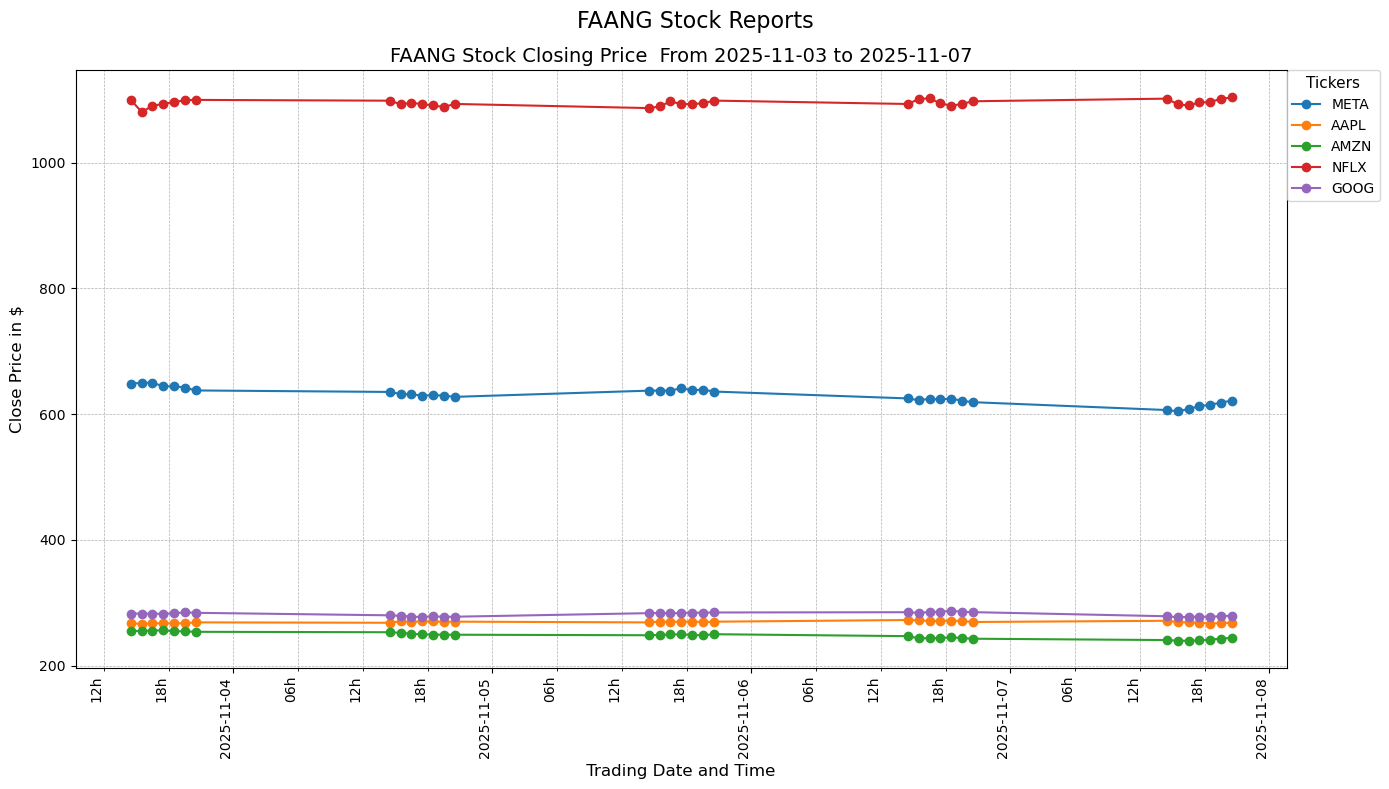

INFO:root:Plot saved to ./plots/20251109_213504.png


✓ Status: 0, Message: Plotting - Return Code: 0, Message: Success, File: ./plots/20251109_213504.png, File: Success


In [22]:
print("Smoke Test : Plotting")
return_code,return_message,filename = plot_data(show_plot=True)
print_status(return_code, f"Plotting - Return Code: {return_code}, Message: {return_message}, File: {filename}", return_message)


# Problem 3: Script #
Create a Python script called faang.py in the root of your repository. Copy the above functions into it and it so that whenever someone at the terminal types ./faang.py, the script runs, downloading the data and creating the plot. Note that this will require a shebang line and the script to be marked executable. Explain the steps you took in your notebook.

## Assignment: Problem 3 Requirements Specification##


* []✅ Ensure the plot is closed after saving to free up resources.

✅
Here is a checklist of all the tasks required to create the final, runnable script:

**1. Script File Setup**

* [✅] Create a new file named faang.py.

* [✅] Ensure the file is saved in the root directory of the repository.

**2. Script Content & Structure**

* [✅] Add a "shebang" line at the very top (e.g., #!/usr/bin/env python3).

* [✅] Include all necessary import statements at the top (for yfinance, pandas, matplotlib, os, sys, etc.).

* [✅] Copy the get_data() function (from Problem 1) into the script.

* [✅] Copy the plot_data() function (from Problem 2) into the script.

* [✅] Include any helper functions needed by get_data or plot_data (like get_latest_file).

* [✅] Create a main() function to control the script's execution.

* [✅] Add the if __name__ == "__main__": block at the bottom to call the main() function.

**3. Script Execution Logic**

* [✅] Inside main(), ensure that get_data() is called first.

* [✅] Inside main(), ensure that plot_data() is called after get_data() successfully completes.

* [ ] Add error handling to stop the script if get_data() fails.

**4. Permissions & Running**

* [ ] The script must be made "executable" (using the chmod +x faang.py command in the terminal).

* [ ] The script must run successfully from the terminal when the user types ./faang.py.

**5. Documentation (Meta-Task)**

* [ ] Provide a separate explanation (e.g., in the notebook) detailing the steps taken to create the script, what the shebang line does, and how to make the script executable.

# Smoke Test

Import the "faang.py" module , and run the get_data() and plot_data() functions

INFO:root:Start Date: 2025-11-02, End Date: 2025-11-09
c:\Users\cw171001\OneDrive - Teradata\Documents\GitHub\PFDA_computer_architecture\faang.py:95: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_data = yf.download(tickers, interval=interval, group_by='ticker',start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed
INFO:root:Starting data plotting...
INFO:root:Getting the latest file from ./data/
INFO:root:Latest file: ./data\20251109_215804.csv
INFO:root:Successfully loaded data from ./data\20251109_215804.csv. Shape: (35, 25)
INFO:root:Data covers from 2025-11-03 to 2025-11-07


✓ Status: 0, Message: Data Retrieval - Return Code: 0, Message: Success, File: ./data/20251109_215804.csv, File: Success


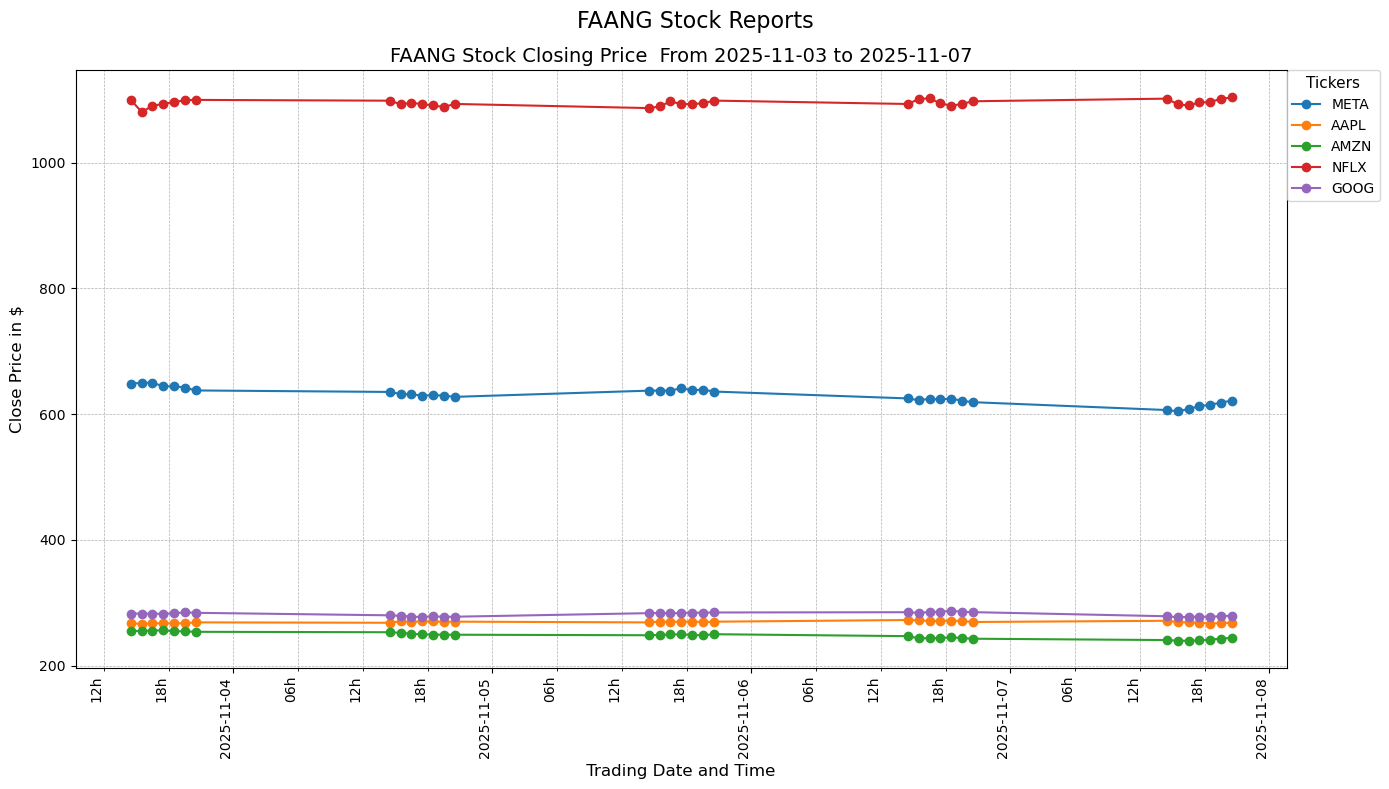

INFO:root:Plot saved to ./plots/20251109_215804.png


✓ Status: 0, Message: Plotting - Return Code: 0, Message: Success, File: ./plots/20251109_215804.png, File: Success


In [25]:
import faang as faang
# Smoke Test
# Import the "faang.py" module , and run the get_data() and plot_data() functions
return_code, return_message, file_name = faang.get_data()
print_status(return_code, f"Data Retrieval - Return Code: {return_code}, Message: {return_message}, File: {file_name}", return_message)
return_code, return_message, png_file_name = faang.plot_data(show_plot=True)
print_status(return_code, f"Plotting - Return Code: {return_code}, Message: {return_message}, File: {png_file_name}", return_message)

__The End__